<a href="https://colab.research.google.com/github/AldarXV/123/blob/master/Yolo_not_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Детекция объектов

В этом задании нам предстоит обучить одностадийный детектор, используя [данные с платформы kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection). Нашей задачей будет определить наличие маски на лице.

In [ ]:
! pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 18.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=367e5d3243b0494d604eef9fd5c0a439f01c08061c4fab8b8aa4dd171838ffc8
  Stored in directory: /root/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
# Download the dataset
!wget --quiet --show-progress "https://www.dropbox.com/s/yqjtopocpy6y82e/masks_dataset.tar?dl=1" -O masks_dataset.tar
!tar -xf masks_dataset.tar

masks_dataset.tar   100%[===================>] 397.81M  16.7MB/s    in 26s     


## Данные

Данные уже предобработаны для простоты работы с ними. Разметка находится в  `masks_dataset/annotations.json` в формате PascalVOC (`x_min`, `y_min`, `x_max`, `y_max`, `cls`). В нашей случае у детекций лица есть два класса: наличие и отсутствие маски.

In [ ]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import albumentations as A
import albumentations.pytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm.auto import tqdm

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирование батчей для обучения.

In [ ]:
class MasksDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="masks_dataset", train=True, seed=10):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"
        with open(self.root/"annotations.json") as f:
            annotations = np.array(json.load(f))

        np.random.seed(seed)
        permutation = np.random.permutation(len(annotations))

        # Train/test split for later evaluation
        if train:
            self.annotations = annotations[permutation[:int(len(annotations) * 0.8)]].tolist()
        else:
            self.annotations = annotations[permutation[int(len(annotations) * 0.8):]].tolist()

    

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image = np.array(Image.open(self.root/ann["folder"]/ann["filename"]))[...,:3]
        bboxes = ann["bboxes"]

        return self.transform(image=image, bboxes=bboxes)

    def __len__(self):
        return len(self.annotations)

Ниже определяем стандартные нормализации и приведение размера к 256x256.


In [ ]:
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

train_transform = A.Compose(
    [A.Resize(256,256), 
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.3)
)

test_transform = A.Compose(
    [A.Resize(256, 256),
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.5)
)

In [ ]:
train_ds = MasksDataset(transform=train_transform, train=True)
test_ds = MasksDataset(transform=test_transform, train=False)

Теперь, когда мы загрузили данные, нам нужно посмотреть на них собственными глазами, прежде чем обучать какие-либо модели. Завершите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и отображает эти прямоугольники на изображениях. (Формат описан выше).


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    fig, axes = plt.subplots(2,len(images)//2 + len(images) % 2, figsize=(10,8),dpi=100)
    for i,ax in enumerate(axes.reshape(-1)):
        ax.axis(False)
        if i >= len(images): break
        ax.imshow(
            images[i].permute(1,2,0) * torch.tensor(imagenet_stats['std'])[None,None,:] 
          + torch.tensor(imagenet_stats['mean'])[None,None,:]
        )

        for bbox in bboxes[i]:
            if bbox[4]==1:
              ax.text(bbox[0], bbox[1]-5, 'Mask', color='green')
              ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, color='green'))
            else:
              ax.text(bbox[0], bbox[1]-5, 'No mask', color='red')
              ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, color='red'))
      
    fig.tight_layout()
    fig.show()

У вас должно получиться нечто подобное:

In [ ]:
out = [train_ds[i] for i in range(100)]
#visualize([o['image'] for o in out], [o['bboxes'] for o in out])

## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 8x8. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx8x8x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b['image'], b['bboxes']) for b in batch])))

    imgs = torch.stack(imgs)
    b,_,h,w = imgs.shape

    # fill out target for all boxes
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1))

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box =(xmax-xmin)/w
        h_box =(ymax-ymin)/h

        # Посчитайте координаты центра и сдвиги
        cx =(xmax+xmin)/2
        cy =(ymax+ymin)/2
        cx_idx =torch.Tensor.long(cx//downsample)
        cy_idx =torch.Tensor.long(cy//downsample) 
        cx_box =(cx-cx_idx*downsample)/downsample 
        cy_box =(cy-cy_idx*downsample)/downsample 

        target[i, :, cy_idx, cx_idx] = torch.stack([cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes])

    return {'image': imgs, 'target': target}

Ниже вы можете увидеть пример, как выглядит решетка размера 8 на 8 на исходном изображении:

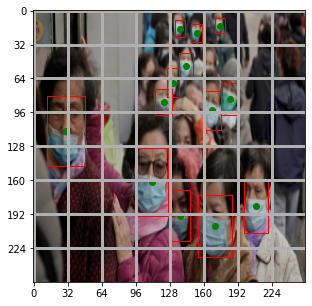

In [ ]:
fig,ax=plt.subplots(figsize=(5,5))
i = 20

img = (train_ds[i]['image'].permute(1,2,0) * torch.tensor(imagenet_stats["std"]).view(1,1,-1) + 
         torch.tensor(imagenet_stats["mean"]).view(1,1,-1))
bboxes = torch.tensor(train_ds[i]['bboxes'])

ax.imshow(img);
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-', linewidth=3)

for bbox in bboxes:
    # TODO remove and add instructions
    xmin,ymin,xmax,ymax = bbox[:-1]
    w = xmax-xmin
    h = ymax-ymin
    with_mask = bbox[-1]
    ax.add_patch(patches.Rectangle((xmin,ymin), w,h, fill=False, color="red"))

cx = (bboxes[:,0] + bboxes[:,2])/2
cy = (bboxes[:,1] + bboxes[:,3])/2

ax.scatter(cx,cy, color="green", marker="o")

fig.show()

Реализуйте аналогичные принципы, чтобы задекодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить тот же набор прямоугольников с корректными размерами и координатами.

* Оставьте те пиксели, в которых вероятность наличия коробки больше чем threshold.
* Отнормируйте и сдвиньте предсказанные центры
* Отнормируйте предсказанные центры

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.5):
    b,c,h,w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    mask_data=[]
    for batch in range(b):
      new_list=[]
      for i in range(w):
        for j in range(h):
          if pred[batch,:, i, j][-2]>threshold:
            if pred[batch,:, i, j][-1]>threshold:
              fff=pred[batch,:, i, j]
              c_x, c_y= j*upsample+fff[0]*upsample,i*upsample+fff[1]*upsample
              x_min, x_max, y_min, y_max=c_x-fff[2]*img_w/2, c_x+fff[2]*img_w/2, c_y-fff[3]*img_h/2, c_y+fff[3]*img_h/2
              new_list.append((float(x_min), float(y_min), float(x_max), float(y_max), 1))
            else:
              fff=pred[batch,:, i, j]
              c_x, c_y= j*upsample+fff[0]*upsample,i*upsample+fff[1]*upsample
              x_min, x_max, y_min, y_max=c_x-fff[2]*img_w/2, c_x+fff[2]*img_w/2, c_y-fff[3]*img_h/2, c_y+fff[3]*img_h/2
              new_list.append((float(x_min), float(y_min), float(x_max), float(y_max), 0))

      mask_data.append(new_list)
    return mask_data

Реализуйте модель. Первым делом примените первые 4 блока ResNet'a. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Медленно уменьшая количество каналов до 6. Последним слоем обязательно должна быть свертка. Так как все значения, которые мы предсказываем находятся в отрезке от 0 до 1 (благодаря нормировке), мы после финальной свертки еще применим сигмоиду.

In [ ]:
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        for p in self.resnet.parameters():
            p.requires_grad = False
        self.conv1 = self.resnet.conv1
        self.bn1 = self.resnet.bn1
        self.relu = self.resnet.relu
        self.maxpool = self.resnet.maxpool

        self.conv2 = nn.Conv2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.conv3 = nn.Conv2d(32, 17, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(17)
        self.relu2=nn.ReLU()
        self.conv4 = nn.Conv2d(17, 14, 3)
        self.conv5 = nn.Conv2d(14, 12, 3)
        self.bn3 = nn.BatchNorm2d(12)
        self.relu3=nn.ReLU()
        self.conv6 = nn.Conv2d(12, 8, 3)
        self.conv7 = nn.Conv2d(8, 6, 3)

    def forward(self, img):
        # Первые 4 слоя Resneta
        out = self.conv1(img)
        out = self.bn1(out)
        out=self.relu(out)
        out=self.maxpool(out)

        out = self.conv2(out)
        out = self.conv3(out)
        out = self.bn2(out)
        out=self.relu2(out)       
        out= self.conv4(out)
        out= self.conv5(out)
        out = self.bn3(out)
        out=self.relu3(out)
        out= self.conv6(out)
        out= self.conv7(out)

        out = F.sigmoid(out)
        return out

Реализуйте функцию потерь. В тех клетках, где есть детекция, мы должны пропустить потери по размерам прямоугольника (MSE), классу детекции (кросс-энтропия) и наличию объекта (кросс-энтропия) (5-й канал). Во всех остальных пикселя мы пропускаем только потери по отсутствию там объекта. 

In [ ]:
def yolo_v1_loss(pred, target):
    pred_1=pred[:,4,:,:]
    target_1=target[:,4,:,:]
    nonzeros=torch.nonzero(target_1)
    target_for_mse=[]
    pred_for_mse=[]
    target_for_class=[]
    pred_for_class=[]
    for nonz in nonzeros:
      target_for_mse.append(target[nonz[0],:4,nonz[1], nonz[2]])
      pred_for_mse.append(pred[nonz[0],:4,nonz[1], nonz[2]])
      target_for_class.append(target[nonz[0],5,nonz[1], nonz[2]])
      pred_for_class.append(target[nonz[0],5,nonz[1], nonz[2]])
    loss=torch.nn.CrossEntropyLoss() #Кросс-энтропия
    output=loss(pred_1, target_1)
    loss_mse=torch.nn.MSELoss()
    output_mse=loss_mse(torch.stack(target_for_mse), torch.stack(pred_for_mse))
    output1=loss(torch.stack(target_for_class), torch.stack(pred_for_class))
    return output+output_mse+output1

Стандартный цикл обучения:

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda:0")

torch.manual_seed(21)
model = YOLOv1().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for e in tqdm(range(5)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        img = batch["image"].to(device)
        target = batch["target"].to(device)

        pred = model(img)
        loss = yolo_v1_loss(pred, target)
        pbar.set_postfix(loss=f"{loss.item():.3f}")
        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

<ipython-input-9-5942d367e3e6>:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  cx_idx =torch.Tensor.long(cx//downsample)
<ipython-input-9-5942d367e3e6>:22: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  cy_idx =torch.Tensor.long(cy//downsample)


Epoch 0 done; Train loss 119.997;


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1 done; Train loss 119.936;


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2 done; Train loss 119.906;


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3 done; Train loss 119.893;


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4 done; Train loss 119.884;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

<ipython-input-9-5942d367e3e6>:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  cx_idx =torch.Tensor.long(cx//downsample)
<ipython-input-9-5942d367e3e6>:22: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  cy_idx =torch.Tensor.long(cy//downsample)


In [ ]:
pred = model(batch["image"].to(device)).cpu().detach()

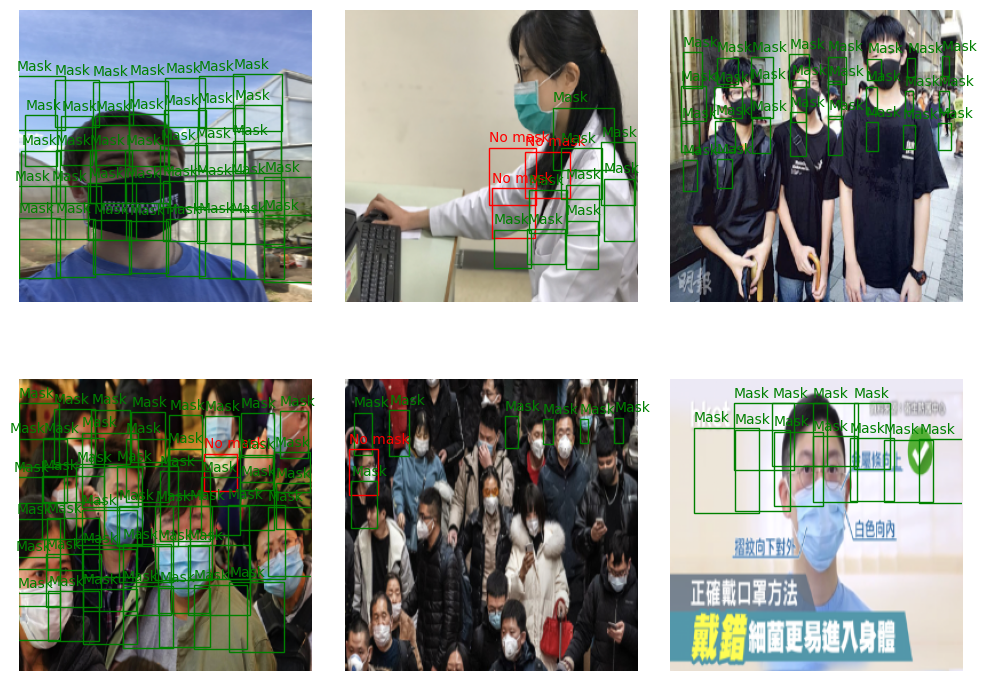

In [ ]:
visualize(batch['image'], decode_prediction(pred))

Если вам интересны улучшения в ваш детектор, вы можете посмотреть на следующие статьи:
* https://pytorch.org/blog/torchvision-ssd-implementation
* https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection